In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.kuka.reaching import KukaReaching
from stage.utils.nn import use_gpu
use_gpu()

In [ ]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [ ]:
savepath = parentdir + '/data/kuka/'

In [ ]:
task = KukaReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nq, nv, nu, nx = task.nq, task.nv, task.nu, task.nx
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub
v_lb, v_ub = -100 * torch.ones_like(q_lb), 100 * torch.ones_like(q_ub)

In [ ]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.pd import PD

na = 14
gain_ub = torch.Tensor([30, 15, 30, 30, 5, 3, 0.1])
gain_lb = 0. * torch.ones((nq))
action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))
actor = Actor(na, PD(nq, nv, nu), action_lb, action_ub)

task.cost.actor = actor

In [ ]:
# Setup model learning

from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx

ensemble_size = 5
nn_epochs = 10
batch_size = 64
    
dynamics = ProbabilisticEnsemble(nx, nq, nv, na, dt_control, 
                                 DefaultDx,
                                 ensemble_size, 
                                 learning_rate = 0.001)

dynamics.state_lb = torch.cat((q_lb, v_lb))
dynamics.state_ub = torch.cat((q_ub, v_ub))

In [ ]:
# Setup controller

from stage.controllers.pets import PETS

plan_horizon = 30
n_particles = 10
pop_size = 400
assert n_particles % ensemble_size == 0

controller = PETS(dynamics, task.cost, actor,
                  plan_horizon, n_particles, pop_size)

In [ ]:
# Setup learner
from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller)

In [ ]:
controller.regularize(1)
_ = learner.learn(100, verbose=True)
learner.save_training_data(savepath+'data_pd_reg')

In [24]:
controller.regularize(1)
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  0.21212690512339274
obs. reward:  -112.379364
act. reward:  -0.09769924


In [25]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)

predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
print (predicted_err.mean())
print (predicted_err.std())

tensor(1.1449, grad_fn=<MeanBackward0>)
tensor(1.2526, grad_fn=<StdBackward0>)


In [26]:
task_horizon = task.task_horizon

traj_pred_mean = torch.mean(traj_pred, dim=1)
traj_pred_std = torch.std(traj_pred, dim=1)
traj_pred_mean = traj_pred_mean.detach().cpu().numpy()
traj_pred_std = traj_pred_std.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

desired = task.cost.desired.repeat((task_horizon, 1))
desired = desired.detach().cpu().numpy()

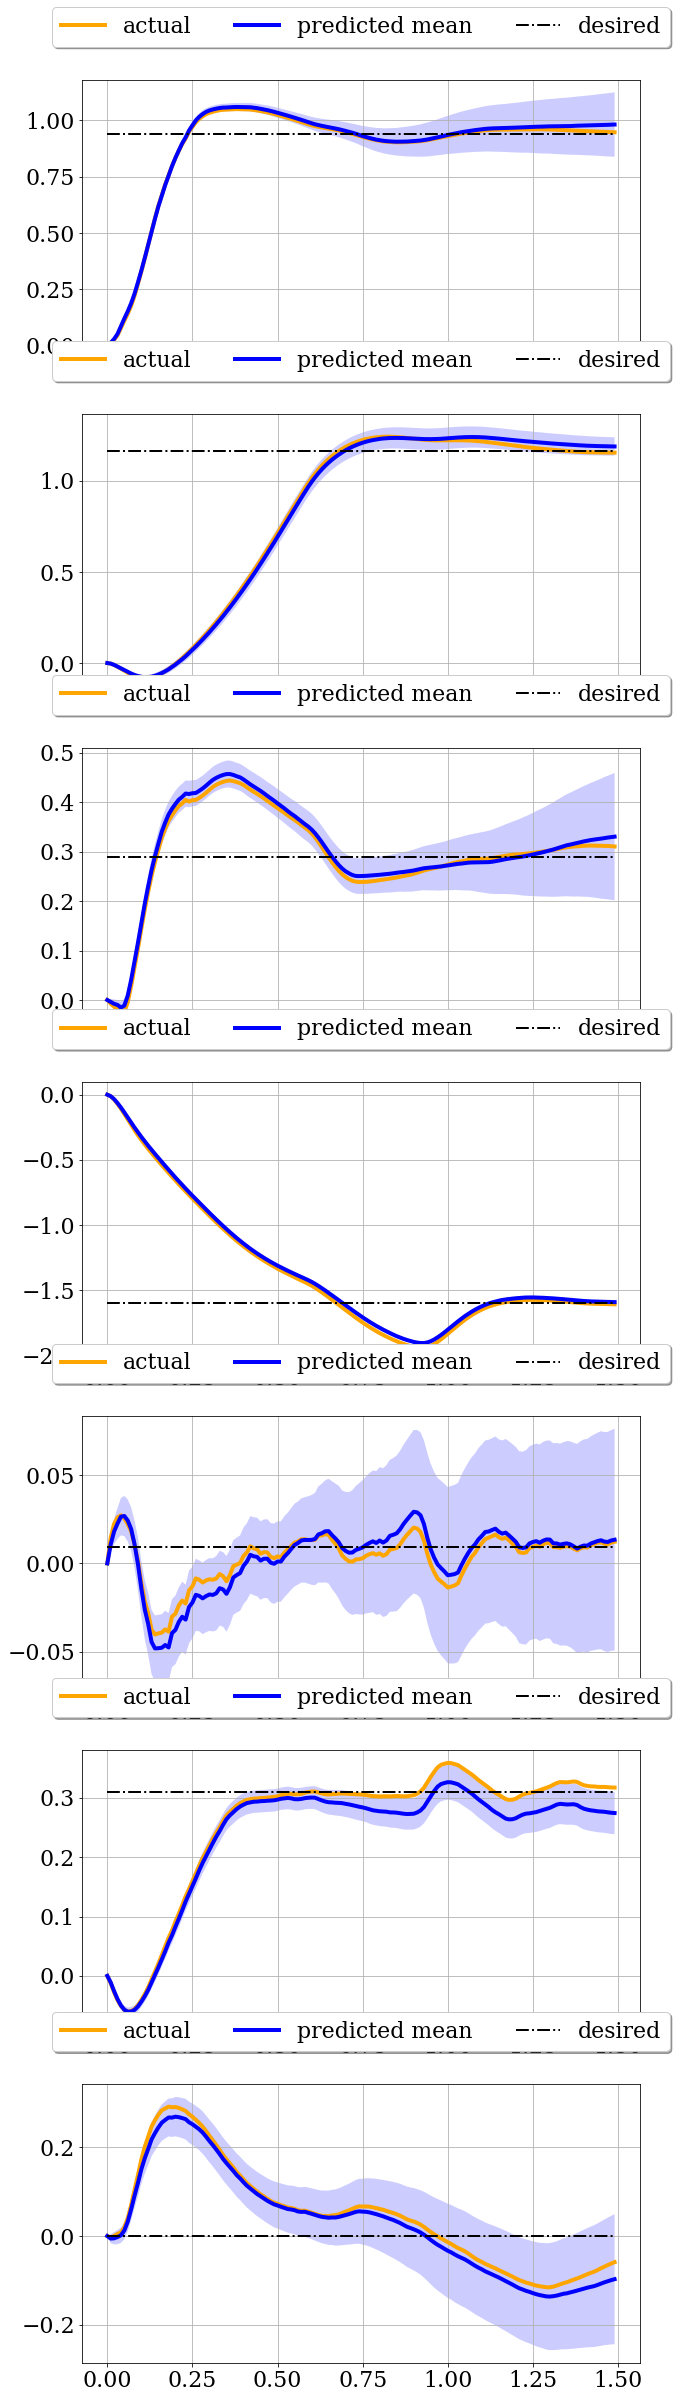

In [27]:
d = nq
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
dlb = traj_pred_mean - traj_pred_std
ub = traj_pred_mean + traj_pred_std

for i in range(d):
    ax[i].plot(t, traj[:, i], lw=4, color='orange', label='actual')
    ax[i].plot(t, traj_pred_mean[:, i], lw=4, color='b', label='predicted mean')
    ax[i].plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
    lb = traj_pred_mean - traj_pred_std
    ub = traj_pred_mean + traj_pred_std
    ax[i].fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax[i].grid()
#     _ = ax[i].set_ylim([-3.2, 3.2])
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
             ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')

In [31]:
nensemble = 5
nb = 3
arr = torch.randn(nensemble, nb, 2)
dim = arr.shape[-1]
reshaped = arr.view(nensemble * nb, dim)
# transposed = reshaped.transpose(0, 1)
# reshaped = transposed.contiguous().view(-1, dim)

In [29]:
# import numpy as np
# from stage.tasks.twolink.reaching import TwoLinkReaching
# from stage.utils.nn import use_gpu
# use_gpu()
# savepath = parentdir + '/data/kuka/'


# data_train = np.load(savepath+'data_pd_reg.npy')
# task = KukaReaching(render=True)
# task.visualize_training_data(data_train, 0)